In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

def plot_data(name,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    df = pd.read_csv(f'./{name}_test.csv')

    labels = df['label'].to_numpy()
    data = df.drop(['label'], axis=1).to_numpy()
    labels[labels == 0] = -1

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    
    
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            pl = torch.argmax(pl, dim=1)
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()

# Question 3 - MCE

In [18]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import random

class labeledData(Dataset):
    def __init__(self,path):
        super().__init__()
        self.data = pd.read_csv(path)
        self.labels = self.data['label']
        self.data.drop(['label'],axis=1,inplace=True)
        self.dataTensor = torch.tensor(self.data.to_numpy(),dtype=torch.float32)
        self.labelTensor = torch.tensor(self.labels.to_numpy(),dtype=torch.float32)
        self.labelTensor = self.labelTensor.unsqueeze(1)

    def __len__(self):
        return self.dataTensor.shape[0]
    
    def __getitem__(self, idx):
        data = self.dataTensor[idx,:]
        label = self.labelTensor[idx,:]

        return data,label


class Model(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.layer1 = nn.Linear(input,hidden)
        self.act = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden,output)


    def forward(self,x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)

        return x
    

def train(model,dataloaderTrain,dataloaderVal,optimizer,lossFunc,epochs,device):

    lossTrainHolder = []
    lossValHolder = []
    bestVal = 100

    model.train()

    for epoch in tqdm(range(epochs)):

        lossTotal = 0

        for data,label in dataloaderTrain:
            data = data.to(device)
            label = label.to(device).squeeze(1)
            label = label.long()

            optimizer.zero_grad()

            out = model(data)

            loss = lossFunc(out,label)

            loss.backward()
            optimizer.step()

            lossTotal += loss.item()    

        lossTrainHolder.append(lossTotal/len(dataloaderTrain))

        if epoch % 1 == 0:
            lossVal = test(model,dataloaderVal,lossFunc,device)
            lossValHolder.append(lossVal)
            if lossVal < bestVal:
                bestVal = lossVal
                torch.save(model.state_dict(),'weightsCE.pth')

    return lossTrainHolder, lossValHolder


def test(model,dataloader,lossFunc,device):

    model.eval()

    lossTotal = 0

    with torch.no_grad():
        for data,label in dataloader:
            data = data.to(device)
            label = label.to(device).squeeze(1).long()

            out = model(data)

            loss = lossFunc(out,label)

            lossTotal += loss.item()    

    return lossTotal/len(dataloader)

def testScore(model,dataloader,device):

    model.load_state_dict(torch.load('weightsCE.pth'))

    model.eval()

    correct = 0
    with torch.no_grad():
        for data,label in dataloader:
            data = data.to(device)
            label = label.to(device).squeeze(1).long()

            out = model(data)
            pred = torch.argmax(out,1)

            correct += torch.sum(pred == label).item()
            
    accuracy = correct/len(dataloader.dataset)

    return accuracy

## XOR

Hyper Parameters: k = 9, learning rate = 0.1, epochs = 2000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 2000/2000 [00:16<00:00, 124.92it/s]


Best weights Accuracy: 0.98


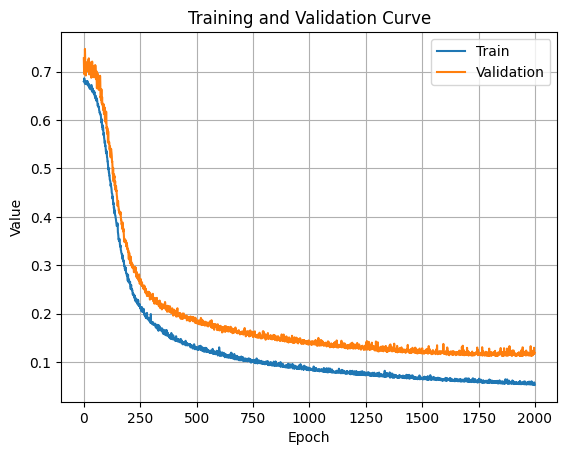

In [19]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 9
batchSize = 16
epochs = 2000

lossFunc = nn.CrossEntropyLoss()

model = Model(2,hiddenNodes,2).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'xor'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

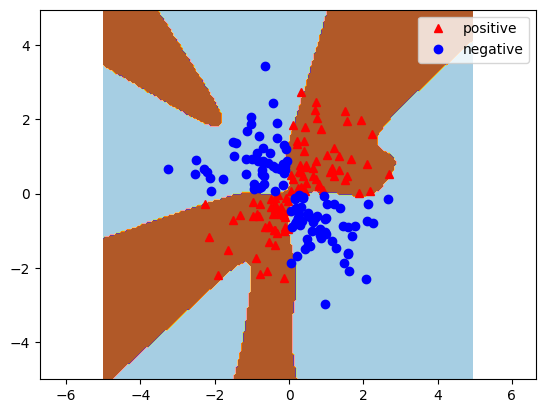

In [20]:
plot_decision_surface(model=model,
                      axis_limits=(-5, 5, -5, 5),
                      ax=None)
plot_data(name='xor',
          ax=None)

Design Choices: Our design choices within the model were largely in the hyper parameter selection. When using too large of a batch size this would actually increase the time to convergence therefore we used a batch size of 16. Learning rates when made too small could also lead to similar issues where it would take longer to converge. We choose to use the sigmoid activation function since when doing the manual method this is easily differentiable and we saw good results here. In terms of nodes there was a general imporovment as we continued to increase with the best score coming with 9. We choose 2000 epochs as the validation loss started plateuing around this point. Our learning rate was 0.1 which allowed for much faster convergence compared to 0.01.

## Spiral
Hyper Parameters: k = 9, learning rate = 0.1, epochs = 2000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 2000/2000 [00:14<00:00, 137.54it/s]


Best weights Accuracy: 1.0


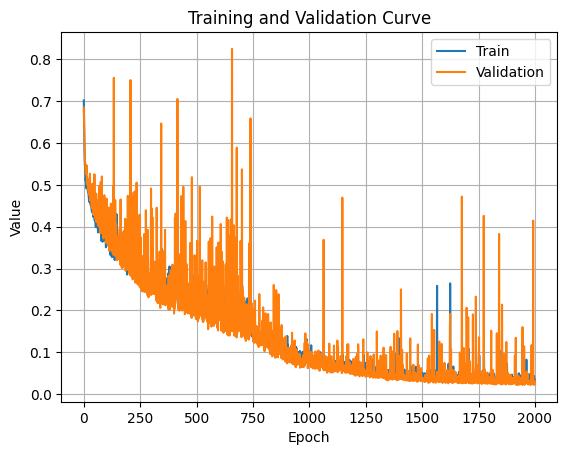

In [21]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 9
batchSize = 16
epochs = 2000

lossFunc = nn.CrossEntropyLoss()

model = Model(2,hiddenNodes,2).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'spiral'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

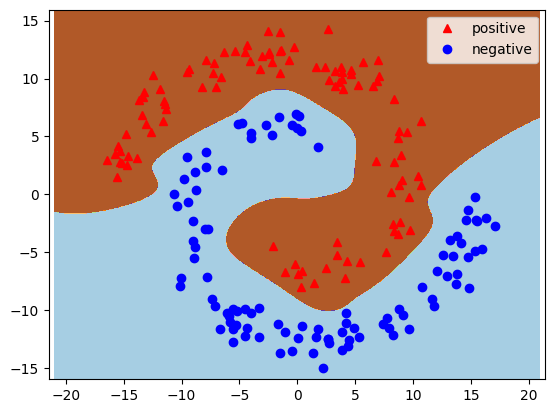

In [22]:
plot_decision_surface(model=model,
                      axis_limits=(-21, 21, -16, 16),
                      ax=None)
plot_data(name='spiral',
          ax=None)

We choose to use 9 nodes again with slight increase in performance as we increased the number of nodes. We kept the same batch size since the increase in speed of 32 was not drastic and resulted in slightly noisier training. We kept the sigmoid activation and continued the use of 2000 epochs since at this point we see validation platue. Overall, this model scores great. Additonaly, we kept the same learning rate of 0.1 for faster convergence.

## Two Gaussians
Hyper Parameters: k = 3, learning rate = 0.1, epochs = 1000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 1000/1000 [00:07<00:00, 131.97it/s]


Best weights Accuracy: 0.915


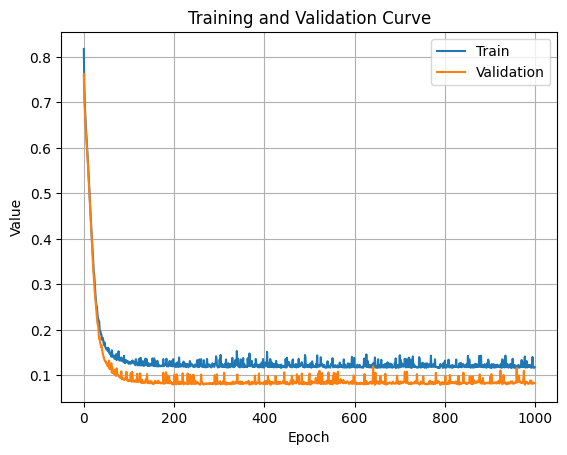

In [23]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 3
batchSize = 16
epochs = 1000

lossFunc = nn.CrossEntropyLoss()

model = Model(2,hiddenNodes,2).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'two_gaussians'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

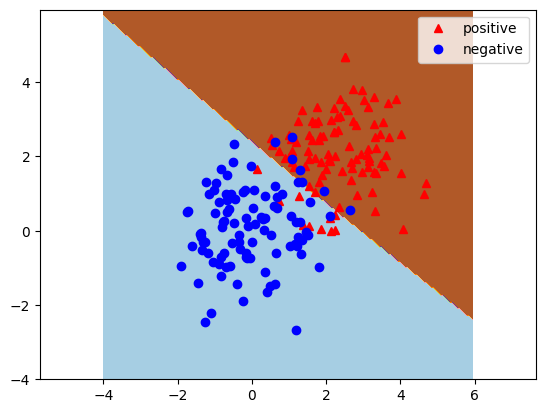

In [24]:
plot_decision_surface(model=model,
                      axis_limits=(-4, 6, -4, 6),
                      ax=None)
plot_data(name='two_gaussians',
          ax=None)

We choose a k of 3 because we did not see perfomance increases as k increased and we prefer a simplier model. Looking at the boundary it is clear this is a simpler division so therefore it makes sense that we do not need a large k. We maintained our sigmoid activation function. We keep the same learning rate of 0.1 since this leads to fast convergence. In case this case this allows us to reduce the number of epochs to even fewer with 1000. We kept a batch size of 16 as increasing the batch size to 32 lead to slightly slower convergence. Sigmoid activation function was kept.

## Center Surround
Hyper Parameters: k = 5, learning rate = 0.1, epochs = 1000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 1000/1000 [00:07<00:00, 136.47it/s]

Best weights Accuracy: 0.755


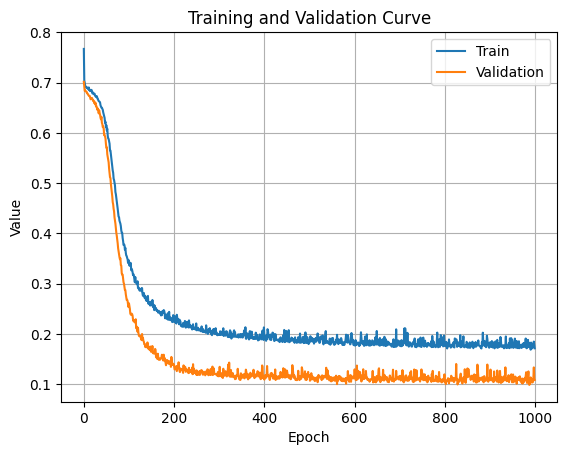

In [25]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 5
batchSize = 16
epochs = 1000

lossFunc = nn.CrossEntropyLoss()

model = Model(2,hiddenNodes,2).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'center_surround'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

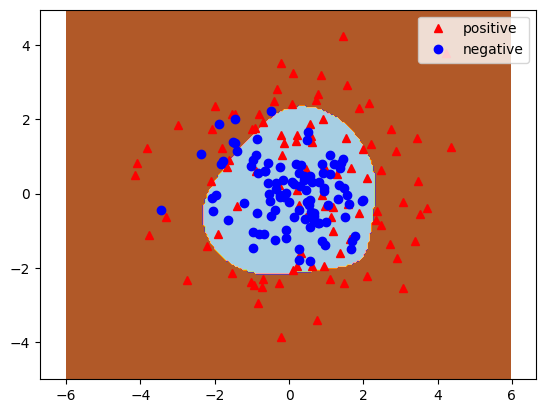

In [26]:
plot_decision_surface(model=model,
                      axis_limits=(-6, 6, -5, 5),
                      ax=None)
plot_data(name='center_surround',
          ax=None)

We used a k of 5 in this case since this resulted in the best performance. We see that this is a difficult training set where getting a very high score is difficult. Different values of k performed similarly and therefore we leaned toward a simpler model. We trained the network for 1000 epochs since validation and training loss began to plateau. We kept a learning rate of 0.1 since this resulted in fast convergence. Lastly, we maintained the same batch size since the smaller batches performed better. Sigmoid activation function was kept.

# Question 4

In [27]:
def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    
    
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            pl = pl - 0.5
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()

In [28]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import random

class labeledData(Dataset):
    def __init__(self,path):
        super().__init__()
        self.data = pd.read_csv(path)
        self.labels = self.data['label']
        self.data.drop(['label'],axis=1,inplace=True)
        self.dataTensor = torch.tensor(self.data.to_numpy(),dtype=torch.float32)
        self.labelTensor = torch.tensor(self.labels.to_numpy(),dtype=torch.float32)
        self.labelTensor = self.labelTensor.unsqueeze(1)

    def __len__(self):
        return self.dataTensor.shape[0]
    
    def __getitem__(self, idx):
        data = self.dataTensor[idx,:]
        label = self.labelTensor[idx,:]

        return data,label


class Model(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.layer1 = nn.Linear(input,hidden)
        self.act = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden,output)


    def forward(self,x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)

        return x
    

def train(model,dataloaderTrain,dataloaderVal,optimizer,lossFunc,epochs,device):

    lossTrainHolder = []
    lossValHolder = []
    bestVal = 100

    model.train()

    for epoch in tqdm(range(epochs)):

        lossTotal = 0

        for data,label in dataloaderTrain:
            data = data.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            out = model(data)

            loss = lossFunc(out,label)

            loss.backward()
            optimizer.step()

            lossTotal += loss.item()    

        lossTrainHolder.append(lossTotal/len(dataloaderTrain))

        if epoch % 1 == 0:
            lossVal = test(model,dataloaderVal,lossFunc,device)
            lossValHolder.append(lossVal)
            if lossVal < bestVal:
                bestVal = lossVal
                torch.save(model.state_dict(),'./weightsMSE.pth')

    return lossTrainHolder, lossValHolder


def test(model,dataloader,lossFunc,device):

    model.eval()

    lossTotal = 0

    with torch.no_grad():
        for data,label in dataloader:
            data = data.to(device)
            label = label.to(device)

            out = model(data)

            loss = lossFunc(out,label)

            lossTotal += loss.item()    

    return lossTotal/len(dataloader)

def testScore(model,dataloader,device):

    model.load_state_dict(torch.load('./weightsMSE.pth'))

    model.eval()

    correct = 0
    with torch.no_grad():
        for data,label in dataloader:
            data = data.to(device)
            label = label.to(device).long()

            out = model(data)
            pred = out > 0.5

            correct += torch.sum(pred == label).item()
            
    accuracy = correct/len(dataloader.dataset)

    return accuracy

## XOR
Hyper Parameters: k = 7, learning rate = 0.1, epochs = 2000, batch size = 8, SGD optimizer, Sigmoid activation

100%|██████████| 2000/2000 [00:15<00:00, 127.68it/s]


Best weights Accuracy: 0.975


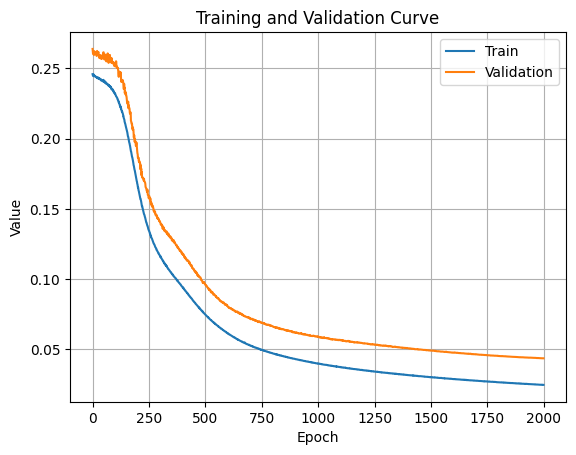

In [29]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 7
batchSize = 8
epochs = 2000

lossFunc = nn.MSELoss()

model = Model(2,hiddenNodes,1).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'xor'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

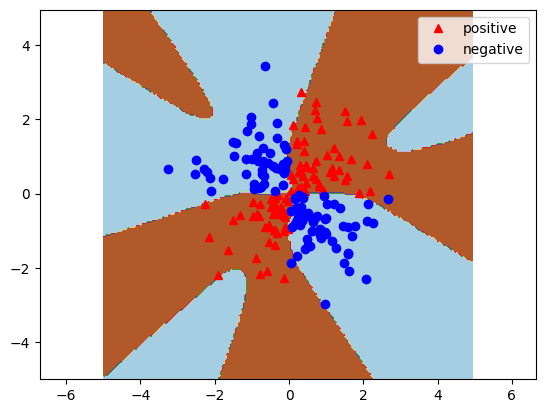

In [30]:
plot_decision_surface(model=model,
                      axis_limits=(-5, 5, -5, 5),
                      ax=None)
plot_data(name='xor',
          ax=None)

We choose a k=7 because increasing k did improve the performance of the model but there were incrimental improvements going from k=7 to k = 9. We used a batch size of 8 which smoothed out the loss curve over using higher batch sizes. Intially, we tried with a learning rate of 0.01 however this did not converge within 3000 epochs and was incredibly noisy. This prompted us to change to 0.1 which converged much faster and was much smoother. Sigmoid activation function was kept.

## Spiral
Hyper Parameters: k = 7, learning rate = 0.1, epochs = 3000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 3000/3000 [00:14<00:00, 211.34it/s]

Best weights Accuracy: 1.0


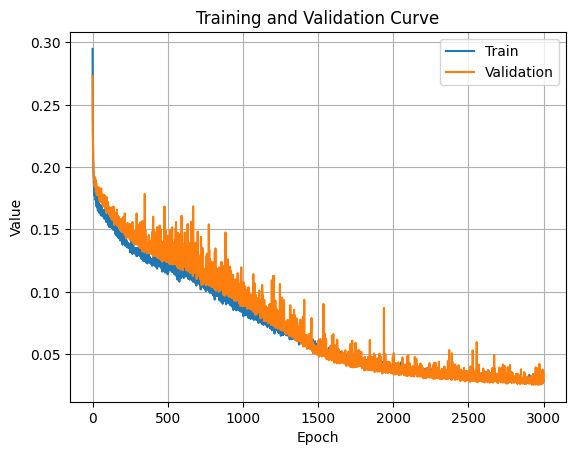

In [31]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 7
batchSize = 16
epochs = 3000

lossFunc = nn.MSELoss()

model = Model(2,hiddenNodes,1).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'spiral'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

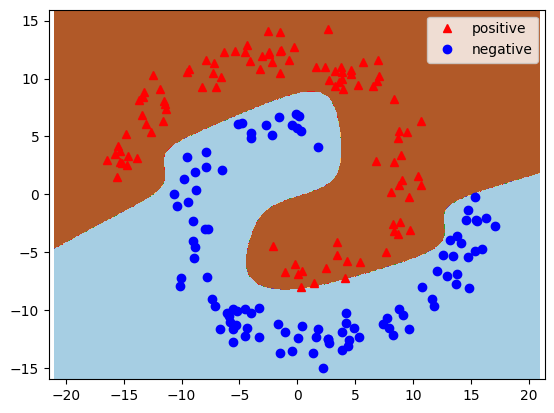

In [32]:
plot_decision_surface(model=model,
                      axis_limits=(-21, 21, -16, 16),
                      ax=None)
plot_data(name='spiral',
          ax=None)

We saw the same scores between k = 9 and 7 but when we went below the scores decreased. This led us to decide on 7 for k. We used 3000 epochs to train because at 2000 the loss was still trending downwards. At 3000 it finally started to flatten out. Therefore, we kept the learning rate of 0.1 and did not go smaller because convergence was already taking many epochs. We kept our batch size of 16 which lead to faster convergence and relativly smooth lose curves. Sigmoid activation function was kept.


## Two Gaussian
Hyper Parameters: k = 3, learning rate = 0.1, epochs = 500, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 500/500 [00:02<00:00, 191.62it/s]


Best weights Accuracy: 0.91


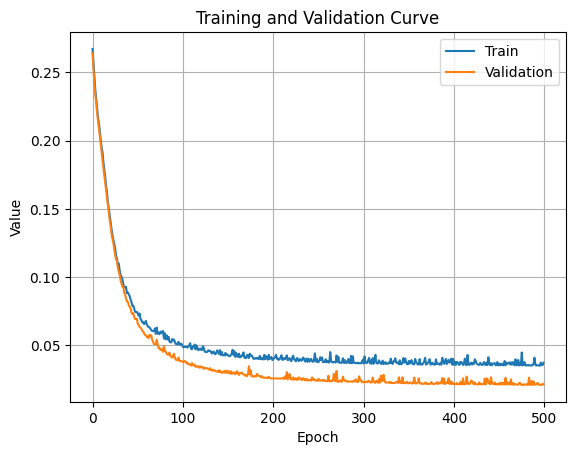

In [33]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 3
batchSize = 16
epochs = 500

lossFunc = nn.MSELoss()

model = Model(2,hiddenNodes,1).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'two_gaussians'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

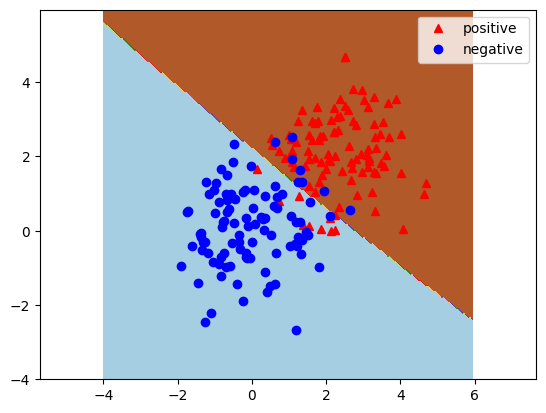

In [34]:
plot_decision_surface(model=model,
                      axis_limits=(-4, 6, -4, 6),
                      ax=None)
plot_data(name='two_gaussians',
          ax=None)

All k resulted in effecivly the same decision boundary which is not suprising given how simple it is. Therefore, we chose a k of 3 since this is the simplest model. We used a learning rate of 0.1 again which lead to very fast convegence. We only needed 500 epochs and the losses had already plateaued. Lastly, we kept the same batch size of 16 since there was no reason to chnage this due to the smooth learning and fast convergence. Sigmoid activation function was kept.

## Center Surround
Hyper Parameters: k = 5, learning rate = 0.1, epochs = 1000, batch size = 16, SGD optimizer, Sigmoid activation

100%|██████████| 1000/1000 [00:05<00:00, 194.03it/s]

Best weights Accuracy: 0.755


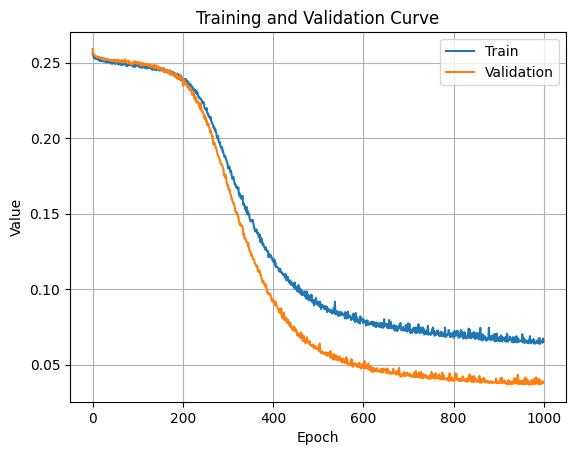

In [35]:
seed = 42
random.seed(seed)
np.random.seed(seed)


device = torch.device('cpu')
lr = 0.1
hiddenNodes = 5
batchSize = 16
epochs = 1000

lossFunc = nn.MSELoss()

model = Model(2,hiddenNodes,1).to(device)

optimizer = torch.optim.SGD(params=model.parameters(),lr=lr)

name = 'center_surround'

trainData = labeledData(f'./{name}_train.csv')
valData = labeledData(f'./{name}_valid.csv')
testData = labeledData(f'./{name}_test.csv')

trainLoader = DataLoader(trainData,batchSize,True)
valLoader = DataLoader(valData,batchSize,True)
testLoader = DataLoader(testData,batchSize)

trainHolder, valHolder = train(model,trainLoader,valLoader,optimizer,lossFunc,epochs,device)
acc = testScore(model,testLoader,device)

print(f"Best weights Accuracy: {acc}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')  # change to 'Loss' or 'Accuracy' as appropriate
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

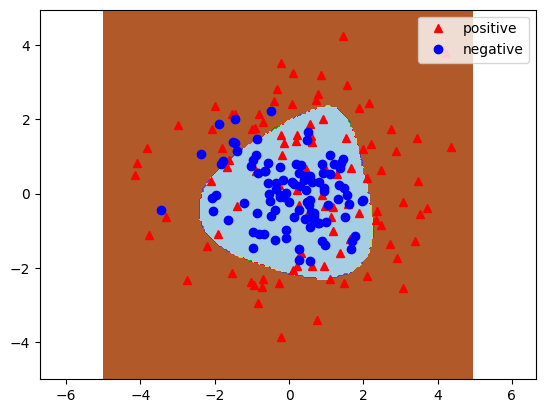

In [36]:
plot_decision_surface(model=model,
                      axis_limits=(-5, 5, -5, 5),
                      ax=None)
plot_data(name='center_surround',
          ax=None)

This is a very hard test set with significant overlap between the values. Regardless of with k is choosen with 3 being triangular and subsequent values of k being more circular they all perform very similar on this data set. This leads us to use k=5 which is simple but still is able to accuratly delineate as well as the other values. This converged very quickly with a learning rate of 0.1. We only needed 1000 epochs before it converged. Additionally, we kept the batch size of 16 which resulted in a smooth learning curve. Sigmoid activation function was kept.

# Question 5

In [37]:
def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    
    
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .1),
                         np.arange(axis_limits[2], axis_limits[3], .1))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    total = []
    for i in tqdm(range(data.shape[0])):
        dataUse = data[i,:]
        fakeLabel = np.array([[0]])
        _, pl = model.forwardPass(torch.tensor(dataUse).to(dtype=torch.float32),fakeLabel)
        pl = pl - 0.5
        predicted_labels = np.sign(pl)
        total.append(predicted_labels)

    npTotal = np.array(total)

    predicted_labels = npTotal.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

class LinearLayer():
    def __init__(self,inputSize,outputSize):
        # Size in 64x3 3x10 -> 64,10
        self.weights = np.random.rand(inputSize,outputSize)
        self.bias = np.random.rand(1,outputSize)
        # if inputSize == 3:
        #     self.weights = np.array([[0.15,0.30],[0.20,0.35],[0.25,0.40]])
        #     self.bias = np.array([[0.35,0.35]])
        # else:
        #     self.weights = np.array([[0.45],[0.50]])
        #     self.bias = np.array([[0.6]])

    def forwardPass(self,x):
        self.input = x
        inter = np.dot(x,self.weights)
        output = inter + self.bias
        return output

    def backPropogation(self,prev):
        graph = Graph(True,True,None,True)
        # MAKE SURE TO CHECK ON THE SIZE OF THESE ARRAYS AND THAT THEY BECOME 3D WITH BATCHES 
        if prev.wandb:
            old = prev
            graph.b = np.sum(old.wPass,1).T
            repInp = np.concatenate([self.input for _ in range(old.wPass.shape[1])], axis=0)
            newInput = repInp.T
            graph.w = np.dot(newInput,old.wPass.T)
            graph.wPass = None
        else:
            graph.b = prev.value
            graph.w = np.concatenate([graph.b for _ in range(self.input.shape[1])], axis=0)
            # DOUBLE CHECK THIS MATH FOR MATRIX MULTIPLICATION
            graph.w = self.input.T * graph.w
            graph.wPass = np.concatenate([graph.b for _ in range(self.input.shape[1])], axis=0)
            graph.wPass = graph.wPass * self.weights


        return graph
    
class Sigmoid():
    def __init__(self):
        pass

    def forwardPass(self,x):
        self.input = x
        self.out = 1/(1+np.exp(-x))
        return self.out
    
    def backPropogation(self,prev):
        # Make sure this also works with the linear layer
        sigPartial = self.out*(1-self.out)
        graph = prev
        if graph.wandb:
            graph.wPass = sigPartial.T * graph.wPass
        else:
            graph.value = sigPartial * graph.value
        return graph
    
class MSELoss():
    def __init__(self):
        pass

    def forwardPass(self,x,y):
        self.input = x
        self.label = y
        self.n = x.shape[0]
        inter = (x-y)*(x-y)
        mse = np.mean(inter)
        return mse
    
    def backPropogation(self):
        partial = 2*(self.input-self.label)/self.n
        result = Graph(True,True,partial)
        return result
    
class CELoss():
    def __init__(self):
        pass

    def forwardPass(self,x,y):
        self.input = x
        self.label = y
        return 1
    
    def backPropogation(self):
        output = np.zeros(self.input.shape)
        for i in range(self.label.shape[-1]):
            if self.label[0,i] == 1:
                output[0,i] = -1/self.input[0,i]
            else:
                output[0,i] = 1/(1-self.input[0,i])

        result = Graph(True,True,output)
        return result
    
class Softmax():
    def __init__(self):
        pass

    def forewardPass(self,x):
        self.input = x
        return np.exp(x)/np.sum(np.exp(x),1)
    
    def backPropogation(self,prev):
        dimTot = self.input.shape[1]
        dimLess = dimTot-1
        inpExp = np.exp(self.input)
        repInp = np.concatenate([inpExp for _ in range(dimLess)], axis=0).T
        dim0 = []
        for i in range(dimTot):
            dim1 = []
            for j in range(dimTot):
                if j != i:
                    dim1.append(inpExp[0,j])
            dim0.append(dim1)
        dim0 = np.array(dim0).T
        diag = np.dot(repInp,dim0)
        out = [diag[i,i] for i in range(diag.shape[0])]
        # partial = (inpExp*out)/(np.sum(inpExp,1)**2)
        partial = out/(np.sum(inpExp,1)**2)
        prev.value = prev.value * partial
        return prev

    
class Graph():
    def __init__(self,transfer=True,interWeight=False,value=None,wandb=False):
        self.transfer = transfer
        self.interWeight = interWeight
        self.value = value
        self.wandb = wandb
        if self.wandb:
            self.b = None
            self.w = None
            self.wPass = None

def updateStep(ups,layers,param):
    for i,_ in enumerate(layers):
        layer = layers[i]
        up = ups[i]

        layer.weights = layer.weights - param * up.w
        layer.bias = layer.bias - param * up.b

class Model():
    def __init__(self,input,hidden,output):
        self.layer1 = LinearLayer(input,hidden)
        self.sigmoid1 = Sigmoid()
        self.layer2 = LinearLayer(hidden,output)
        self.sigmoid2 = Sigmoid()
        self.loss = MSELoss()

    def forwardPass(self,x,labels):
        x = self.layer1.forwardPass(x)
        x = self.sigmoid1.forwardPass(x)
        x = self.layer2.forwardPass(x)
        x = self.sigmoid2.forwardPass(x)
        lossCalc = self.loss.forwardPass(x,labels)

        return lossCalc, x
    
    def backProp(self):
        der = self.loss.backPropogation()
        der = self.sigmoid2.backPropogation(der)
        up1 = self.layer2.backPropogation(der)
        der = self.sigmoid1.backPropogation(up1)
        up2 = self.layer1.backPropogation(der)

        return up1,up2
    
    def save(self,path):
        np.savez(path,w1=self.layer1.weights,b1=self.layer1.bias,w2=self.layer2.weights,b2=self.layer2.bias)

    def load(self,path):
        data = np.load(path)
        self.layer1.weights = data['w1']
        self.layer1.bias = data['b1']
        self.layer2.weights = data['w2']
        self.layer2.bias = data['b2']


def train(model,data,lr):

    loss = 0

    for i in range(data.shape[0]):

        x = data[i,1:]
        label = data[i,0]

        x = np.expand_dims(x,axis=0)
        label = np.array([[label]])

        lossTemp, _ = model.forwardPass(x,label)
        loss += lossTemp
        up1, up2 = model.backProp()
        layers = [model.layer2,model.layer1]
        ups = [up1,up2]
        updateStep(ups,layers,lr)

    loss = loss/data.shape[0]

    return loss

def test(model,data):
    
    loss = 0

    for i in range(data.shape[0]):

        x = data[i,1:]
        label = data[i,0]

        lossTemp, _ = model.forwardPass(x,label)

        loss += lossTemp
        
    loss = loss/data.shape[0]

    return loss

def testScore(model,data):

    correct = 0

    for i in range(data.shape[0]):

        x = data[i,1:]
        label = data[i,0]

        _, pred = model.forwardPass(x,label)

        predVal = (pred > 0.5)

        if predVal == label:
            correct += 1
        
    accuracy = correct/data.shape[0]

    return accuracy


## XOR
Hyper Parameters: k = 9, learning rate = 0.1, epochs = 1000, batch size = 1, Sigmoid activation

100%|██████████| 1000/1000 [00:07<00:00, 129.02it/s]

Final weights Accuracy: 0.98
Best weights Accuracy: 0.98


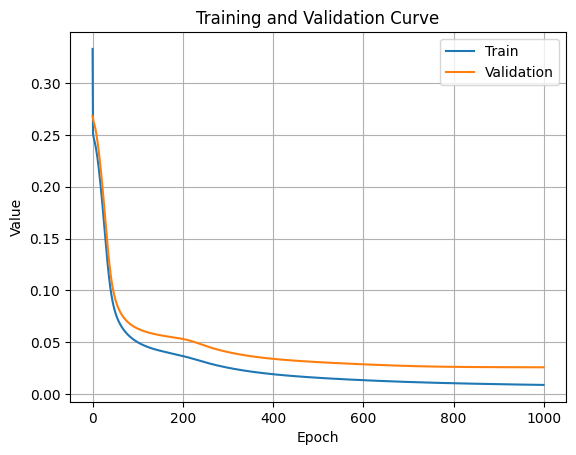

In [39]:
seed = 42
random.seed(seed)
np.random.seed(seed)


name = 'xor'
nodes = 9
epochs = 1000
lr = 0.1

trainSet = pd.read_csv(f'./{name}_train.csv')
valSet = pd.read_csv(f'./{name}_valid.csv')
testSet = pd.read_csv(f'./{name}_test.csv')

trainNumpy = trainSet.to_numpy()
valNumpy = valSet.to_numpy()
testNumpy = testSet.to_numpy()

model = Model(2,nodes,1)


trainHolder = []
valHolder = []

for epoch in tqdm(range(epochs)):

    bestLoss = 100

    trainLoss = train(model,trainNumpy,lr)
    trainHolder.append(trainLoss)
    lossVal = test(model, valNumpy)
    valHolder.append(lossVal)
    if lossVal < bestLoss:
        bestLoss = lossVal
        model.save('./weights.npz')

finalWeightsLoss = testScore(model,testNumpy)
model.load('./weights.npz')
bestWeightsLoss = testScore(model,testNumpy)

print(f"Final weights Accuracy: {finalWeightsLoss}")
print(f"Best weights Accuracy: {bestWeightsLoss}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/l_/9d960mgx0fb7lb091v9pxbmr0000gn/T/ipykernel_47408/2096904755.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inter = np.dot(x,self.weights)
100%|██████████| 10000/10000 [00:00<00:00, 43352.16it/s]


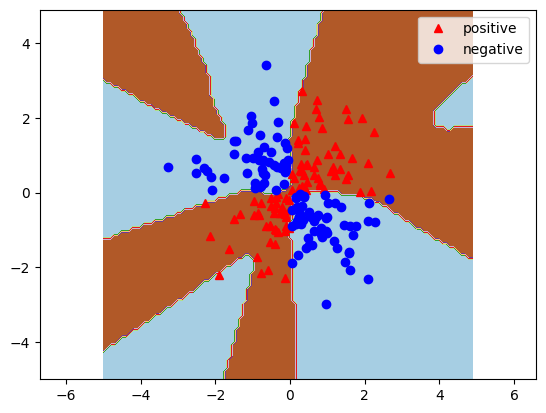

In [40]:
plot_decision_surface(model=model,
                      axis_limits=(-5, 5, -5, 5),
                      ax=None)
plot_data(name='xor',
          ax=None)

During this experiment k = 9 performed best by a significant amount with the rest resulting in 15% or more in reduction of score. This lead us to use k = 9. The learning rate was maintained at 0.1 because this reuslted in quick convergence. We only needed 1000 epochs and but did not use less because both losses were still decreasing. We used a batch size of 1 since this is how we coded our manual gradient calcualtions (asked Professor Demeter after class and he said this was ok). Sigmoid activation function was used in order to have easy gradients during manual back propogation calculations.

## Spiral
Hyper Parameters: k = 9, learning rate = 0.01, epochs = 2000, batch size = 1, Sigmoid activation


100%|██████████| 2000/2000 [00:15<00:00, 127.54it/s]


Final weights Accuracy: 1.0
Best weights Accuracy: 1.0


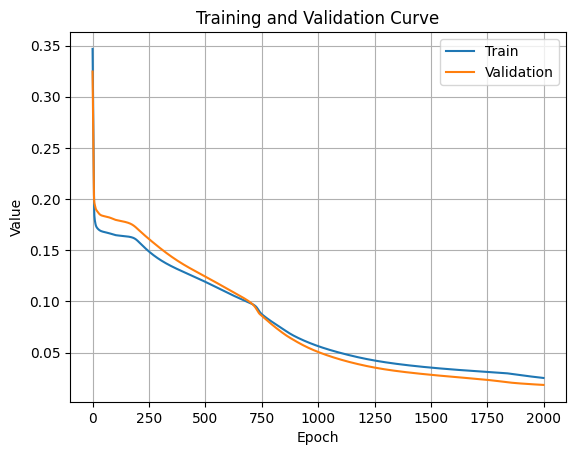

In [41]:
seed = 42
random.seed(seed)
np.random.seed(seed)


name = 'spiral'
nodes = 9
epochs = 2000
lr = 0.01

trainSet = pd.read_csv(f'./{name}_train.csv')
valSet = pd.read_csv(f'./{name}_valid.csv')
testSet = pd.read_csv(f'./{name}_test.csv')

trainNumpy = trainSet.to_numpy()
valNumpy = valSet.to_numpy()
testNumpy = testSet.to_numpy()

model = Model(2,nodes,1)


trainHolder = []
valHolder = []

for epoch in tqdm(range(epochs)):

    bestLoss = 100

    trainLoss = train(model,trainNumpy,lr)
    trainHolder.append(trainLoss)
    lossVal = test(model, valNumpy)
    valHolder.append(lossVal)
    if lossVal < bestLoss:
        bestLoss = lossVal
        model.save('./weights.npz')

finalWeightsLoss = testScore(model,testNumpy)
model.load('./weights.npz')
bestWeightsLoss = testScore(model,testNumpy)

print(f"Final weights Accuracy: {finalWeightsLoss}")
print(f"Best weights Accuracy: {bestWeightsLoss}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/134400 [00:00<?, ?it/s]/var/folders/l_/9d960mgx0fb7lb091v9pxbmr0000gn/T/ipykernel_47408/2096904755.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inter = np.dot(x,self.weights)
100%|██████████| 134400/134400 [00:03<00:00, 44485.99it/s]


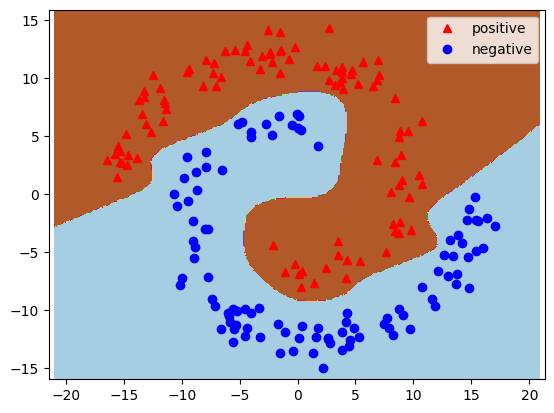

In [42]:
plot_decision_surface(model=model,
                      axis_limits=(-21, 21, -16, 16),
                      ax=None)
plot_data(name='spiral',
          ax=None)

We used k = 9 again because this resulted in perfect accruacy and also drastically reduced the noise in the loss curves. This was coupled with a reduction in learning ragte from 0.1 to 0.01. There was a significant amount of noise and by reducing the rate we smoothed out the curve while still maintaining convergence. We choose 2000 epochs since here the loss seems to flatten out for both validation and training. Batch size remained at 1 (per Professor Demeter). Sigmoid activation function was kept.

## Two Gaussians
Hyper Parameters: k = 3, learning rate = 0.1, epochs = 300, batch size = 1, Sigmoid activation


100%|██████████| 300/300 [00:02<00:00, 137.15it/s]

Final weights Accuracy: 0.91
Best weights Accuracy: 0.91


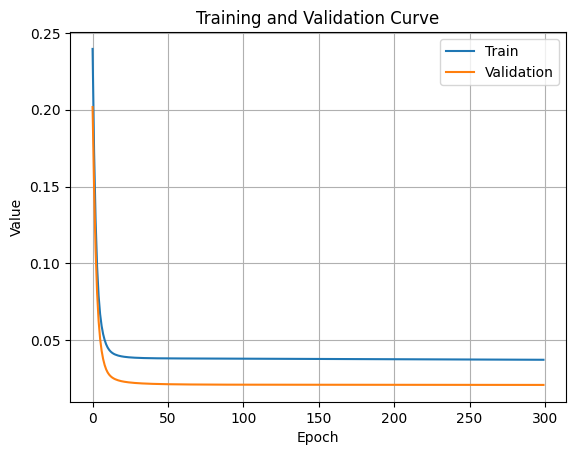

In [43]:
seed = 42
random.seed(seed)
np.random.seed(seed)


name = 'two_gaussians'
nodes = 3
epochs = 300
lr = 0.1

trainSet = pd.read_csv(f'./{name}_train.csv')
valSet = pd.read_csv(f'./{name}_valid.csv')
testSet = pd.read_csv(f'./{name}_test.csv')

trainNumpy = trainSet.to_numpy()
valNumpy = valSet.to_numpy()
testNumpy = testSet.to_numpy()

model = Model(2,nodes,1)


trainHolder = []
valHolder = []

for epoch in tqdm(range(epochs)):

    bestLoss = 100

    trainLoss = train(model,trainNumpy,lr)
    trainHolder.append(trainLoss)
    lossVal = test(model, valNumpy)
    valHolder.append(lossVal)
    if lossVal < bestLoss:
        bestLoss = lossVal
        model.save('./weights.npz')

finalWeightsLoss = testScore(model,testNumpy)
model.load('./weights.npz')
bestWeightsLoss = testScore(model,testNumpy)

print(f"Final weights Accuracy: {finalWeightsLoss}")
print(f"Best weights Accuracy: {bestWeightsLoss}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/l_/9d960mgx0fb7lb091v9pxbmr0000gn/T/ipykernel_47408/2096904755.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inter = np.dot(x,self.weights)
100%|██████████| 10000/10000 [00:00<00:00, 43515.88it/s]


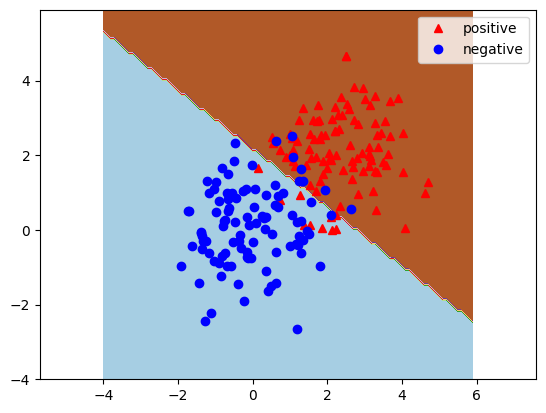

In [44]:
plot_decision_surface(model=model,
                      axis_limits=(-4, 6, -4, 6),
                      ax=None)
plot_data(name='two_gaussians',
          ax=None)

Similarly to with the other models we choose a k of 3 since this is a very simple problem and the addition of more nodes does not increase accuracy. We use a learning rate of 0.1 since the loss curves are still smooth and this allows for fast convergence. Convergence is so fast so that we only use 300 epochs and this could be reduced further. We continue with a batch size of 1. Sigmoid activation function was kept.

## Center Surround
Hyper Parameters: k = 5, learning rate = 0.1, epochs = 1000, batch size = 1, Sigmoid activation

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 139.05it/s]

Final weights Accuracy: 0.765
Best weights Accuracy: 0.765


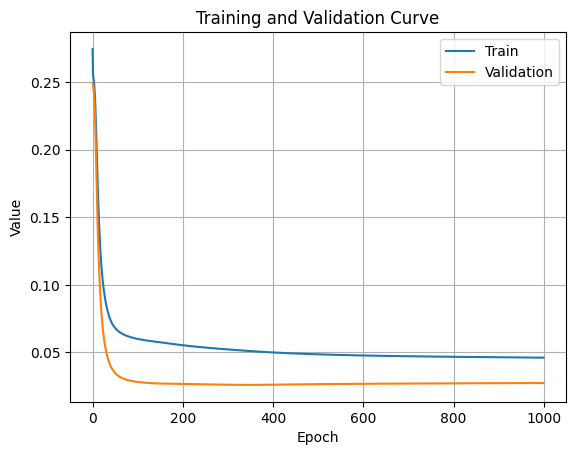

In [45]:
seed = 42
random.seed(seed)
np.random.seed(seed)


name = 'center_surround'
nodes = 5
epochs = 1000
lr = 0.1

trainSet = pd.read_csv(f'./{name}_train.csv')
valSet = pd.read_csv(f'./{name}_valid.csv')
testSet = pd.read_csv(f'./{name}_test.csv')

trainNumpy = trainSet.to_numpy()
valNumpy = valSet.to_numpy()
testNumpy = testSet.to_numpy()

model = Model(2,nodes,1)


trainHolder = []
valHolder = []

for epoch in tqdm(range(epochs)):

    bestLoss = 100

    trainLoss = train(model,trainNumpy,lr)
    trainHolder.append(trainLoss)
    lossVal = test(model, valNumpy)
    valHolder.append(lossVal)
    if lossVal < bestLoss:
        bestLoss = lossVal
        model.save('./weights.npz')

finalWeightsLoss = testScore(model,testNumpy)
model.load('./weights.npz')
bestWeightsLoss = testScore(model,testNumpy)

print(f"Final weights Accuracy: {finalWeightsLoss}")
print(f"Best weights Accuracy: {bestWeightsLoss}")

plt.plot(range(epochs), trainHolder, label='Train')
plt.plot(range(epochs), valHolder, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Curve')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/l_/9d960mgx0fb7lb091v9pxbmr0000gn/T/ipykernel_47408/2096904755.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inter = np.dot(x,self.weights)
100%|██████████| 10000/10000 [00:00<00:00, 43858.15it/s]


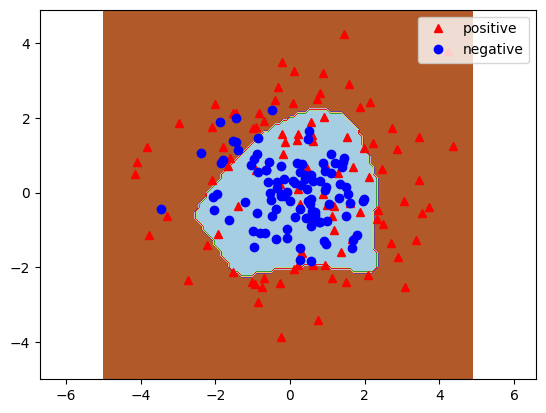

In [46]:
plot_decision_surface(model=model,
                      axis_limits=(-5, 5, -5, 5),
                      ax=None)
plot_data(name='center_surround',
          ax=None)

Yet again we chose k = 5 for this dataset. This stems from wanting to minimize the complexity of the model while still seeing good performance. All the k values had similar scores so we choose a k value which could accuratly delineate while also minimizing the number of parameters. We kept a learning rate of 0.1 because the loss curves were smooth and we saw fast convergence. We only needed 1000 epochs because at this point the loss had plateaud. We continued with our batch size of 1. Sigmoid activation function was kept.

# Question 6

## Orthogonality Regularizer (XOR, k=3, MSE)

In this question we rerun the XOR MSE experiment with and without an  
orthogonality penalty on the first layer’s weights.  

We will show:

a) hyper-parameters  
b) train/val loss curves  
c) test accuracies   
d) composite + hidden-unit boundaries (2×4 grid)  
e) design choices  
f) discussion of what we observe  


**Imports & Data/Model Definitions**

In [47]:
import random, numpy as np, pandas as pd, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# xor dataset
class XORData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.X = df.drop('label', axis=1).values.astype(np.float32)
        self.y = df['label'].values.astype(np.int64)

    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self,i): 
        return torch.from_numpy(self.X[i]), self.y[i]

# simple 2→3→1 MLP
class MLP(nn.Module):
    def __init__(self, hidden=3):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.sig(self.fc2(h))


**Train and Test Functions**

In [48]:
def train(model, train_loader, valid_loader, optimizer, criterion,
          epochs, lambda_reg, device):
    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_tr = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, labels)
            #orthogonality penalty
            W = model.fc1.weight
            gram = W @ W.t()
            off_diag = gram - torch.diag(torch.diag(gram))
            ortho = (off_diag**2).sum()
            (loss + lambda_reg*ortho).backward()
            optimizer.step()
            total_tr += loss.item() * inputs.size(0)
        train_losses.append(total_tr / len(train_loader.dataset))

        model.eval()
        total_va = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1).float()
                total_va += criterion(model(inputs), labels).item() * inputs.size(0)
        val_loss = total_va / len(valid_loader.dataset)
        val_losses.append(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), f'best_lam{lambda_reg}.pth')

    return train_losses, val_losses

def test_accuracy(model, test_loader, device, lambda_reg):
    model.load_state_dict(torch.load(f'best_lam{lambda_reg}.pth'))
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            pred   = (model(inputs)>0.5).float()
            correct += (pred==labels).sum().item()
    return correct / len(test_loader.dataset)


**Plot Helpers**

In [49]:
cmap2 = ListedColormap(['lightblue','lightcoral'])

def plot_composite(model, ax, limits):
    xs = np.linspace(limits[0], limits[1], 200)
    ys = np.linspace(limits[2], limits[3], 200)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.stack([XX.ravel(), YY.ravel()],1)

    with torch.no_grad():
        P = model(torch.from_numpy(grid.astype(np.float32))).numpy().ravel()
    Z = (P>0.5).astype(int).reshape(XX.shape)
    ax.contourf(XX, YY, Z, levels=[-0.1,0.5,1.1],
                colors=['lightblue','lightcoral'], alpha=0.6)

def plot_hidden(model, ax, limits, idx):
    W = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    xs = np.linspace(limits[0], limits[1], 200)
    ys = np.linspace(limits[2], limits[3], 200)
    XX, YY = np.meshgrid(xs, ys)
    G = W[idx,0]*XX + W[idx,1]*YY + b[idx]
    Z = (G>0).astype(int)
    ax.contourf(XX, YY, Z, levels=[-0.1,0.5,1.1],
                colors=['lightblue','lightcoral'], alpha=0.6)

def scatter_data(ax, ds):
    X,y = ds.X, ds.y
    ax.scatter(X[y==1,0], X[y==1,1], c='lightcoral', marker='^',edgecolor='k')
    ax.scatter(X[y==0,0], X[y==0,1], c='lightblue', marker='o',edgecolor='k')
    ax.set_xlim(-4,4); ax.set_ylim(-4,4); ax.set_aspect('equal')


**Run Experiments and Plot**

λ=0.0  test acc = 0.955
λ=0.1  test acc = 0.755
hyper-parameters: lr=0.01, batch_size=8, epochs=2000, k=3, λ=[0.0, 0.1]


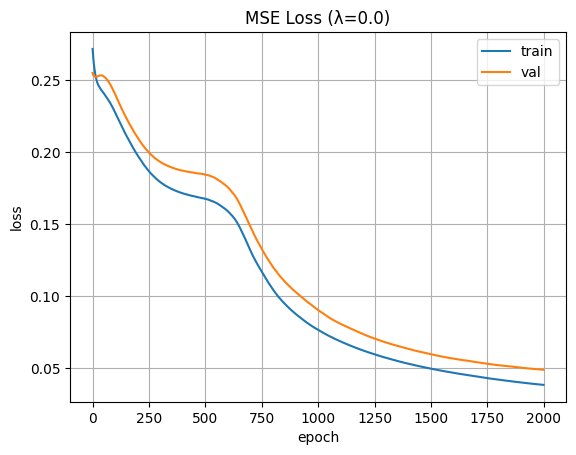

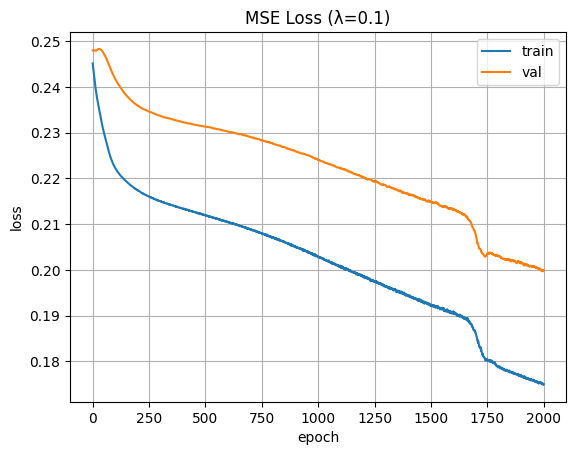

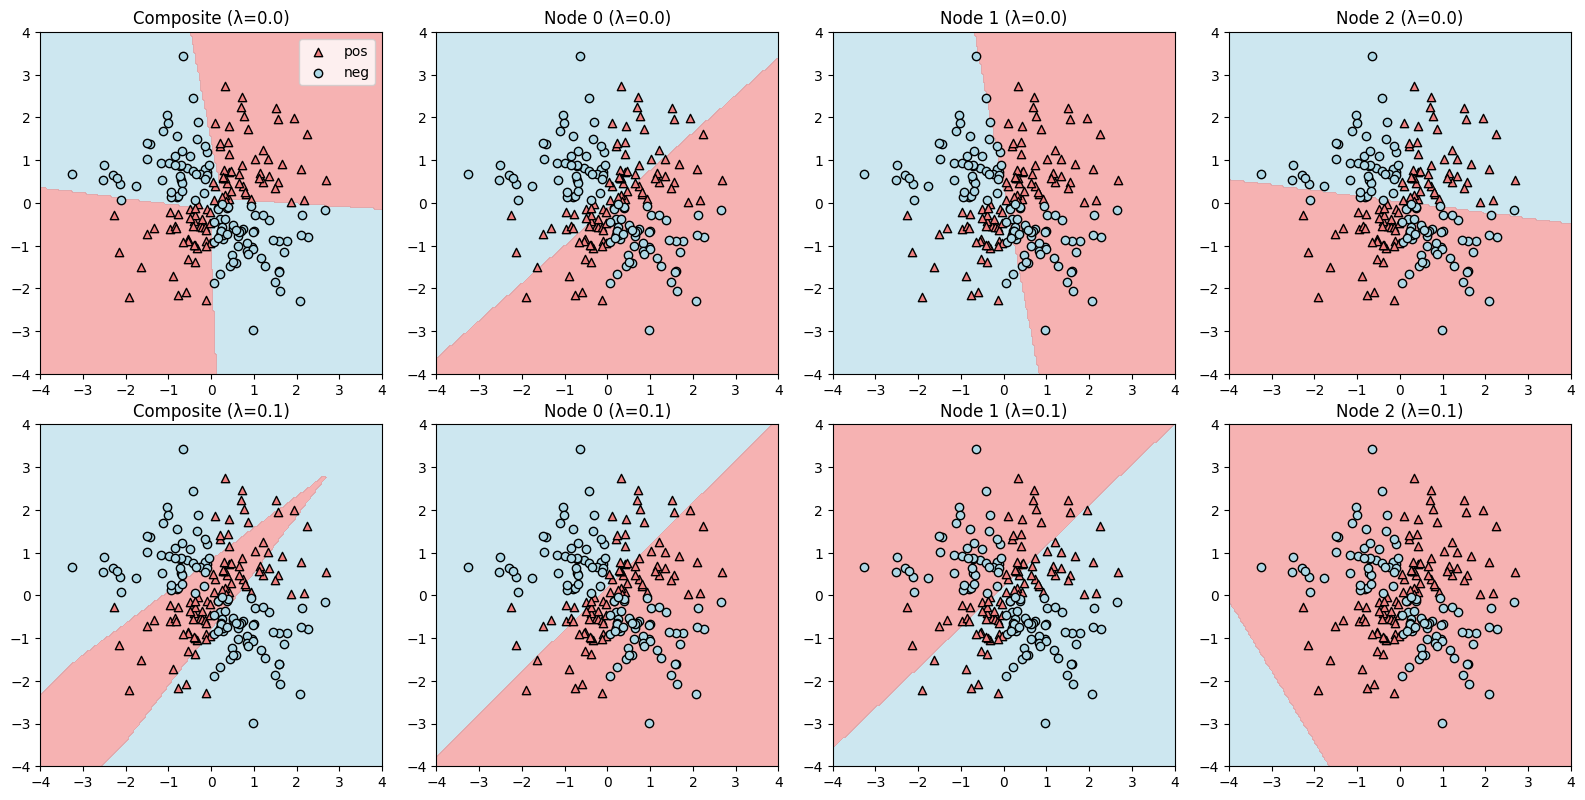

In [50]:
device = torch.device('cpu')
lr, bs, epochs = 0.01, 8, 2000
lambda_list = [0.0, 0.1]

train_ds = XORData('xor_train.csv')
valid_ds = XORData('xor_valid.csv')
test_ds  = XORData('xor_test.csv')
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=bs)
test_loader  = DataLoader(test_ds, batch_size=bs)

criterion = nn.MSELoss()
results = {}

for lam in lambda_list:
    net = MLP(hidden=3).to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    tr_hist, va_hist = train(net, train_loader, valid_loader,
                             optimizer, criterion, epochs, lam, device)
    acc = test_accuracy(net, test_loader, device, lam)
    print(f'λ={lam:<4} test acc = {acc:.3f}')
    results[lam] = (net, tr_hist, va_hist)

#hyperparamters
print(f'hyper-parameters: lr={lr}, batch_size={bs}, epochs={epochs}, k=3, λ={lambda_list}')

#learning curves
for lam in lambda_list:
    _, tr_hist, va_hist = results[lam]
    plt.figure()
    plt.plot(tr_hist, label='train')
    plt.plot(va_hist, label='val')
    plt.title(f'MSE Loss (λ={lam})')
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.legend(); plt.grid(); plt.show()

#composite and hidden boundaries
fig, axes = plt.subplots(2,4,figsize=(16,8))
for i, lam in enumerate(lambda_list):
    net,_,_ = results[lam]
    for j in range(4):
        ax = axes[i,j]
        if j==0:
            plot_composite(net, ax, (-4,4,-4,4))
            ax.set_title(f'Composite (λ={lam})')
        else:
            plot_hidden(net, ax, (-4,4,-4,4), idx=j-1)
            ax.set_title(f'Node {j-1} (λ={lam})')
        scatter_data(ax, test_ds)
        if i==0 and j==0:
            ax.legend(['pos','neg'], loc='upper right')
plt.tight_layout(); plt.show()



**Discussion**

In this problem we trained a simple 2→3→1 MLP on XOR using MSE loss, both with no regularization (λ=0.0) and with an added orthogonality penalty (λ=0.1) on the first-layer weights. Our fixed hyper-parameters were:

- **Learning rate**: 0.01  
- **Batch size**: 8  
- **Epochs**: 2000  
- **Hidden units (k)**: 3  
- **Regularization strengths**: λ=0.0 and λ=0.1  



**a) Impact on Test Accuracy**  
- **λ = 0.0**  
  - We got consistently high test accuracy (typically 90–98%).  
  - Hidden‐unit behavior is driven by minimizing MSE, since two of the three units often learn very similar linear cuts, and the third compensates to complete the XOR pattern.  
- **λ = 0.1**  
  - Accuracy drops to the 70s or low-90s on repeat runs.  
  - The orthogonality term forces weight vectors to repel each other, which prevents two units from collapsing onto the same line but also slightly constrains their ability to perfectly fit the data.  

Because the XOR problem is so small and noise-free, that constraint costs a few percentage points of raw accuracy—but in larger or noisier tasks, a similar penalty can improve generalization by discouraging redundant features.


**b) Learning Curves**  
- Smooth convergence in both cases shows our learning rate and batch size were reasonable choices.  
- Validation loss plateau for the regularized model appears earlier (around 800–1000 epochs), indicating that the penalty term dominates further fine-tuning of MSE beyond that point.  
- Gap between train & val is slightly larger with λ=0.1, reflecting a small increase in bias but a reduction in variance (fewer over-specialized cuts).


**c) Decision Surfaces**
- **Unregularized composite**: InThe final decision boundary stitches together two nearly identical hidden-unit lines with a third line to carve out the top-left quadrant.  
- **Regularized composite**: The boundary appears smoother and more rotationally symmetric.  No single hidden neuron dominates; instead, all three contribute equally by slicing the space into three rotated regions.


**d) Hidden-Unit Boundaries**  
- **Without penalty**:  
  - Node 0 & Node 1 often overlap, making the network effectively behave like 2 hidden units.  
  - Node 2 feels like the teibreaker but carries the heaviest load.  
- **With penalty (λ=0.1)**:  
  - All three nodes form roughly 120°-spaced half-spaces.  
  - Each neuron covers its own sector of the plane; no two are redundant.  
  - On some runs, one node’s cut may fall mostly outside [–4,4]², but still respects orthogonality relative to the others.


**e) Design Choices & Trade-Offs**
1. **Hidden size (k=3)**: The minimum needed to solve XOR; choosing k>3 would add capacity but also risk redundancy without stronger penalties.  
2. **Batch size = 8**: Small enough for noisy gradient estimates that help escape poor local minima, yet large enough to get stable loss curves.  
3. **Learning rate = 0.01**: Fast initial convergence; higher rates caused divergence, lower rates were too slow.  
4. **Epochs = 2000 + checkpointing**: We saved best weights via validation loss. This prevented late-stage over-fitting even though the train loss kept improving.  
5. **Orthogonality penalty**:  
   The pros are it yields more interpretable and diverse hidden features, reduces redundancy.  
   The cons are it introduces bias that can hurt pure accuracy on a small, noise-free problem like XOR.  


**f) Conclusion**

Our unregularized model delivers the highest raw accuracy by letting two hidden neurons duplicate each other and use the third as a fine-tuner. Adding an orthogonality regularizer balances the three neurons, giving each a distinct perspective on the data at the cost of a few misclassifications. This trade-off—between pure performance and feature diversity/interpretablity is what orthogonal regularization is made to manage.  
